<a href="https://colab.research.google.com/github/ajayseeker/Facial-Keypoint-Detection-using-cnn/blob/master/Facialkeypoint_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoint Detection
<p style="text-align:justify"> In this exercise we will build a
CNN for facial key point detection. 
    
Given a set of faces marked with $(x, y)$ coordinates of facial keypoints, say, left_eye left corner, left_eye right corner, right_eye left corner, right_eye right corner etc - can we build and train a model that if given a seen or unseen face will automatically detect the coordinates of the facial keypoints. 

Keypoints across all faces for training are to be ordered consistently. 

The training data and test data are available as csv files. The images in the training set are gray-scale and are of size 96x96. Each image is associated with ground_truth (x, y) coordinates of 15 keypoints (totalling to 30 values) as shown in Figure 1. The model we are going to build is as follows:

i/p-->conv layer-->ReLU-->maxpool-->conv layer-->ReLU-->maxpool-->conv layer-->ReLU-->maxpool-->linear-->ReLU
-->linear-->ReLU-->Linear

The details are as follows:
<span style="color:brown">
<br>
i/p: 1 x 96 x 96
<br>
conv1: in_channels = 1, num_of_filters also called outchannels = 32, kernel_size = (3, 3), stride = (1, 1), no            padding
<br>
pool1: max pooling, kernel_size = (2, 2), no padding
<br>
conv2: in_channels = 32, outchannels = 64, kernel_size = (2, 2), stride = (1, 1), no padding
<br>
pool2: max pooling, kernel_size = (2, 2), no padding
<br>
conv3: in_channels = 64, outchannels = 128, kernel_size = (2, 2), stride = (1, 1), no padding
<br>
pool3: max pooling, kernel_size = (2, 2), no padding
<br>
fc1: in_features = 128, out_features = 500
<br>
fc2: in_features = 500, out_features = 500
<br>
fc3: in_features = 500, out_features = 30
</span>
<br>
<br>
**Dimensions through the model:**
<br>
<br>
1x96x96 $\xrightarrow[\text{relu}]{\text{conv +}}$ 32x94x94 $\xrightarrow[\text{}]{\text{pool}}$ 32x47x47 $\xrightarrow[\text{relu}]{\text{conv +}}$ 64x46x46 $\xrightarrow[\text{}]{\text{pool}}$ 64x23x23$\xrightarrow[\text{relu}]{\text{conv +}}$ 128x22x22 $\xrightarrow[\text{}]{\text{pool}}$ 128x11x11 = 15488$\xrightarrow[\text{relu}]{\text{fc +}}$ 500 $\xrightarrow[\text{relu}]{\text{fc +}}$ 500$\xrightarrow[\text{}]{\text{fc}}$ 30

- You should create a class for building the above model.
- You should create a Dataset class for supplying training, valid and test data to the DataLoader. Since the data is in form of csv files, you should use a csv file reader in the Dataset class to read the csv files. Look and analyse the data to get familiar with it. The train/valid split could be 70-30 or 80-20 rule. The data augumentation to be used for train data and only train data is RandomHorizontalFlip. Note that when the image is flipped, the corresponding keypoints order also will change.
- Use MSE loss as loss criterion. Use SGD with momentum= 0.9  as optimizer.
- You should have a function that plots the train loss and valid loss against number of epochs.
- You should have a function to test the model.
- You should have a function that prints a batch of images with keypoints superimposed on them.
- You should have a function that prints the total number of learnable parameters of the model.
- Your submission deadline is Sep 5th, 2019.

In [0]:
import pandas as pd
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Class for randomly flipping images and modifying labels

In [0]:
class RandomHorizontalFlip(object): #inherits from python's object class
    def __init__(self, prob = 0.5):
        self.prob = prob
        
    def __call__(self, img, label): # a callable class
        if np.random.rand() < self.prob:
            b=np.array(label, dtype=np.float64)
            c=[]
            for i in range(0,len(b)):
                if(i%2==0):
                    if(i > 47.5):
                        c.append(47.5 - (b[i]-47.5))
                    else:
                        c.append(47.5 + (47.5-b[i]))
                else:
                    c.append(b[i])
            c=np.array(c, dtype=np.float64)
            img=img.reshape(96,96)
            img=np.flip(img, axis=1)
            img=img/255.;
            img=img.reshape(1,96,96)
            c=c/96.
            img= torch.tensor(img, dtype=torch.float64)
            c=c[[2, 3, 0, 1, 8, 9, 10, 11, 4, 5, 6, 7, 16, 17, 18, 19, 12, 13, 14,15,20,21, 24,25,22, 23, 26,27, 28,29]]
            c=torch.tensor(c, dtype=torch.float64)
            return img, c
        else:
            img=img/255.
            img=img.reshape(1,96,96)
            label=label/96.
            img=torch.tensor(img, dtype=torch.float64)
            label=torch.tensor(label, dtype=torch.float64)
            return img,label

# Data Loader Class

In [0]:

class FaceDataset(Dataset):
    def __init__(self, sampler="", data_path = '/content/drive/My Drive/DeepLearning/Assgn4/data/training.csv', transform = RandomHorizontalFlip()):
        data=pd.read_csv(data_path)
        data=data.dropna(how='any')
        image=np.array(data["Image"]).reshape(-1,1)
        data=data.drop(['Image'], axis=1)
        data=data.reset_index(drop=True)
        a=np.random.rand(1,30)
        dat=np.random.rand(1, 96, 96)
        for l in range(image.shape[0]):
            dat=np.concatenate((dat, np.fromstring(image[l][0], sep=' ', dtype=np.float64).reshape(1,96,96)), axis=0)
        image=dat[1:,:,:]
        for i in range(image.shape[0]):
            a=np.concatenate((a, np.array(data.loc[i], np.float64).reshape(1,30)), axis=0)
        a=a[1:,:]
        label=a
        self.images=image
        self.transform = transform
        indices = list(range(np.array(image.shape[0])))
        np.random.seed(8)
        np.random.shuffle(indices)
        self.m=int(image.shape[0]*0.25)
        self.sampler=sampler
        if(sampler=='train'):
            self.images = np.array(image[indices[self.m:]])
            self.labels = np.array(label[indices[self.m:]])
        elif(sampler=='valid'):
            self.images = np.array(image[indices[:self.m]])
            self.labels = np.array(label[indices[:self.m]])
        else:
              raise Exception('Wrong keyword argument supplied\n sampler="valid" or sampler="train"') 

    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, i):
        if(self.images.shape[0]<=i):
            raise Exception('Index supplied exceed the total data instances present\n Total datainstances: ', self.images.shape[0], " Index Supplied: ", i)
        image = self.images[i,:,:]
        label = self.labels[i]
        if self.transform:
            image, label = self.transform(image, label)
        else:
            image=image.reshape(1, 96, 96)
            image = image/255.
            image = torch.tensor(image, dtype=torch.float64)
            label = torch.tensor(label, dtype=torch.float64)
            label=label/96.
        return image, label
        
    

In [0]:
def printGrid(images, model):
  if torch.cuda.is_available(): # if gpu available,
      images = images.to(device = 'cuda') 
      outputs = model(images) # do forward propagation
      images=images.to(device = 'cpu')
      outputs=outputs.to(device = 'cpu')
      m=8
      n=int(images.shape[0]/8)
      fig, axes = plt.subplots(n,m)
      fig.set_figwidth(24)
      fig.set_figheight(24)
      images=images*255
      for i in range(n):
        for j in range(m):
          axes[i,j].imshow(np.array(images[i*m+j][0]).reshape(96, 96), cmap='gray')
          v=outputs[i*m+j].detach()
          x=[ np.float32(v[i])*96 for i in range(0,30, 2)]
          y=[ np.float32(v[i])*96 for i in range(1,30, 2)]
          axes[i,j].scatter(x, y, s=5, color='r')
      if(int(images.shape[0])%8==0):
        n=int(images.shape[0])%8
        fig, axes = plt.subplots(1,n)
        fig.set_figwidth(24)
        fig.set_figheight(24)
        for i in range(n):
          axes[0,i].imshow(np.array(images[-1*(i+1)][0]).reshape(96, 96), cmap='gray')
          v=outputs[-1*(i+1)].detach()
          x=[ np.float32(v[i])*96 for i in range(0,30, 2)]
          y=[ np.float32(v[i])*96 for i in range(1,30, 2)]
          axes[0,i].scatter(x, y, s=5, color='r')
  else:
      print("GPU is not available")
  

This Function reads all the test images and plots them along the predicted labels.

In [0]:
def Test(model):
  path="/content/drive/My Drive/DeepLearning/Assgn4/data/test.csv"
  data=pd.read_csv(path)
  data=data.dropna(how='any')
  img=np.array(data["Image"]).reshape(-1,1)
  dat=np.random.rand(1, 96, 96)
  for l in range(img.shape[0]):
    dat=np.concatenate((dat, np.fromstring(img[l][0], sep=' ', dtype=np.float64).reshape(1,96,96)), axis=0)
  img=dat[1:,:,:]
  img=img/255.
  img=img.reshape(-1,1,96,96)
  img=torch.tensor(img, dtype=torch.float64)
  test_loader = DataLoader(img, batch_size=64, shuffle=True, num_workers=4)
  loss_val=0
  for images in test_loader: # for each batch of images and labels
      #print(images.size())
      if torch.cuda.is_available(): # if gpu available,
        images = images.to(device = 'cuda') 
      outputs = model(images) # do forward propagation
      images=images.to(device = 'cpu')
      outputs=outputs.to(device = 'cpu')
      if(outputs.shape[0]==64):
        fig, axes = plt.subplots(8,8)
        fig.set_figwidth(16)
        fig.set_figheight(16)
        img=img*255
        for i in range(8):
          for j in range(8):
            axes[i,j].imshow(np.array(images[i*8+j][0]).reshape(96, 96), cmap='gray')
            v=outputs[i*8+j].detach()
            x=[ np.float32(v[i])*96 for i in range(0,30, 2)]
            y=[ np.float32(v[i])*96 for i in range(1,30, 2)]
            axes[i,j].scatter(x, y, s=5, color='r')
      else:
        fig, axes = plt.subplots(5,11)
        fig.set_figwidth(16)
        fig.set_figheight(16)
        img=img*255
        for i in range(5):
          for j in range(11):
            axes[i,j].imshow(np.array(images[i*5+j][0]).reshape(96, 96), cmap='gray')
            v=outputs[i*5+j].detach()
            x=[ np.float32(v[i])*96 for i in range(0,30, 2)]
            y=[ np.float32(v[i])*96 for i in range(1,30, 2)]
            axes[i,j].scatter(x, y, s=5, color='r')
       
    #fig.savefig('batch_out.jpg')
      

# This class contains the model 

In [0]:
class MyModel(nn.Module): # your model is inheriting from the base class
    def __init__(self): # infeatures is the size of input features
                                              # nclasses is the number of classes
        super().__init__()
        self.conv1=nn.Conv2d(1, 32, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv2=nn.Conv2d(32, 64, 2)
        self.conv3=nn.Conv2d(64, 128,2)
        
        self.fc1 = nn.Linear(128*11*11, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 30)
        self.relu = nn.ReLU()
        self.train_loss=[]
        self.valid_loss=[]
        
    def forward(self, x): # forward method of base class 'Module' overridden here
                          # size of x is (batch_size, infeatures)
        x = self.relu(self.conv1(x))
        x=self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 11 * 11 * 128)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x # size of x here is (batch_size, 1)
    def train_validation_loss(self):
        plt.ion()
        plt.plot(self.train_loss, color='b', label="Training Loss")
        plt.plot(self.valid_loss, color='r', label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Plot")
        plt.legend()
        plt.show()
        plt.close()
       

# This function does the random initialization

In [0]:
def init_params(m):
  if type(m) == nn.Linear or type(m)==nn.Conv2d:
    m.weight.data = torch.randn(m.weight.size(),dtype=torch.float64)*.01
    m.bias.data = torch.zeros(m.bias.size(),dtype=torch.float64)


# Functions below are responsible for training of the model

Training loss at epoch 1:	6.839559830503817


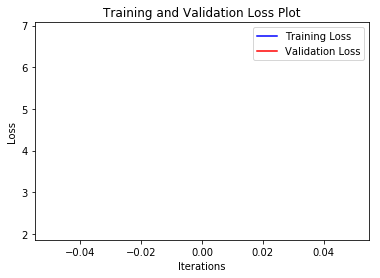

Training loss at epoch 51:	0.02837628002008987


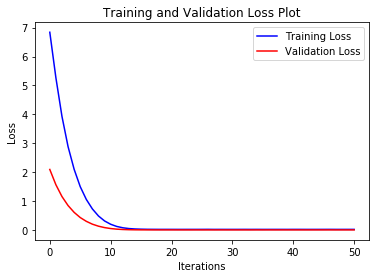

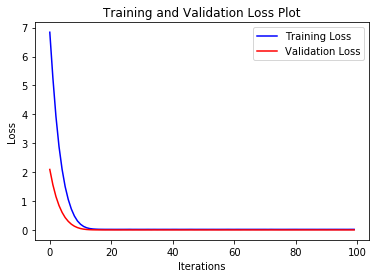

In [0]:

def train(model, loader, val_loader, loss_criterion, optimizer, num_epochs):
  for epoch in range(num_epochs): # for each epoch
    loss_train=0
    loss_val=0
    for images, labels in loader: # for each batch of images and labels
      if torch.cuda.is_available(): # if gpu available,
        images = images.to(device = 'cuda') 
        labels = labels.to(device = 'cuda') # move batch of images and labels to gpu memory
      outputs = model(images) # do forward propagation
      loss = loss_criterion(outputs.squeeze(), labels.to(dtype = torch.float64)) # compute loss
      loss_train += loss.item()
      optimizer.zero_grad() # make sure gradients of parameters are zeroed before backpropagation to avoid accumulation
      loss.backward() # do the backpropagation
      optimizer.step() # update the parameters
    model.train_loss.append(loss_train)
    for images, labels in val_loader: # for each batch of images and labels
      if torch.cuda.is_available(): # if gpu available,
        images = images.to(device = 'cuda') 
        labels = labels.to(device = 'cuda') # move batch of images and labels to gpu memory
      outputs = model(images) # do forward propagation
      loss = loss_criterion(outputs.squeeze(), labels.to(dtype = torch.float64)) # compute loss
      loss_val += loss.item()
      optimizer.zero_grad() # make sure gradients of parameters are zeroed before backpropagation to avoid accumulation
    model.valid_loss.append(loss_val)
   
    if epoch%50 == 0:
      print(f'Training loss at epoch {epoch+1}:\t{loss_train}')
      model.train_validation_loss()
  model.train_validation_loss()
      
     
def main():
  mymodel = MyModel() # instantiate the model
  mymodel.apply(init_params) # initialize parameters
  if torch.cuda.is_available():
    mymodel = mymodel.to(device = 'cuda') # move entire model to gpu memory; all its parameters, buffers are moved to gpu memory
  loss_criterion = nn.MSELoss() # instantiate the loss criterion; since we are predicting real values so loss is choosen to Mean Squared Loss
  optimizer = optim.SGD(mymodel.parameters(), lr=0.008, momentum=0.9) # instantiate optimizer; here we are using stochastic gradient descent with momentum = 0.9
                                                                  # with learning rate as 0.008 
  dset=FaceDataset(sampler="train")  
  val=FaceDataset(sampler='valid', transform=None)
  valid_loader = DataLoader(val, batch_size=64, shuffle=True, num_workers=4)
  train_loader = DataLoader(dset, batch_size=64, shuffle=True, num_workers=4)
  ########################################################################
  
  train(mymodel, train_loader, valid_loader, loss_criterion, optimizer, 100)
  return mymodel
if __name__ == '__main__':
  model = main()


# Performance of model on the Test set.  

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


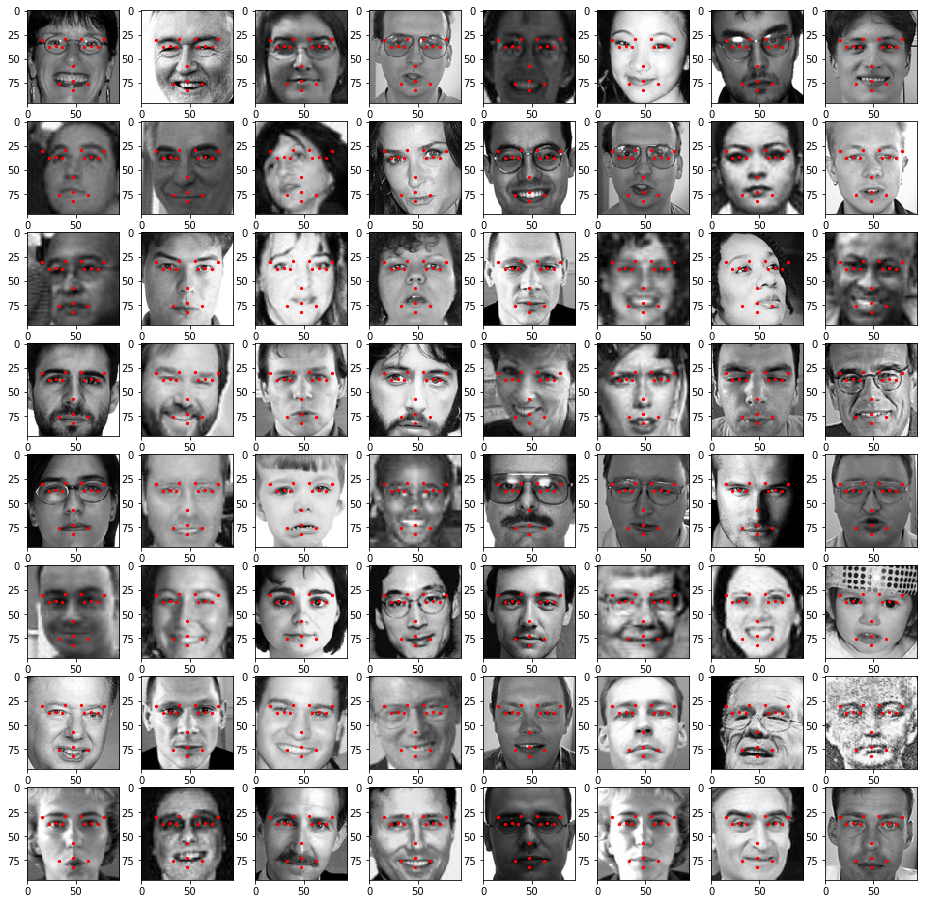

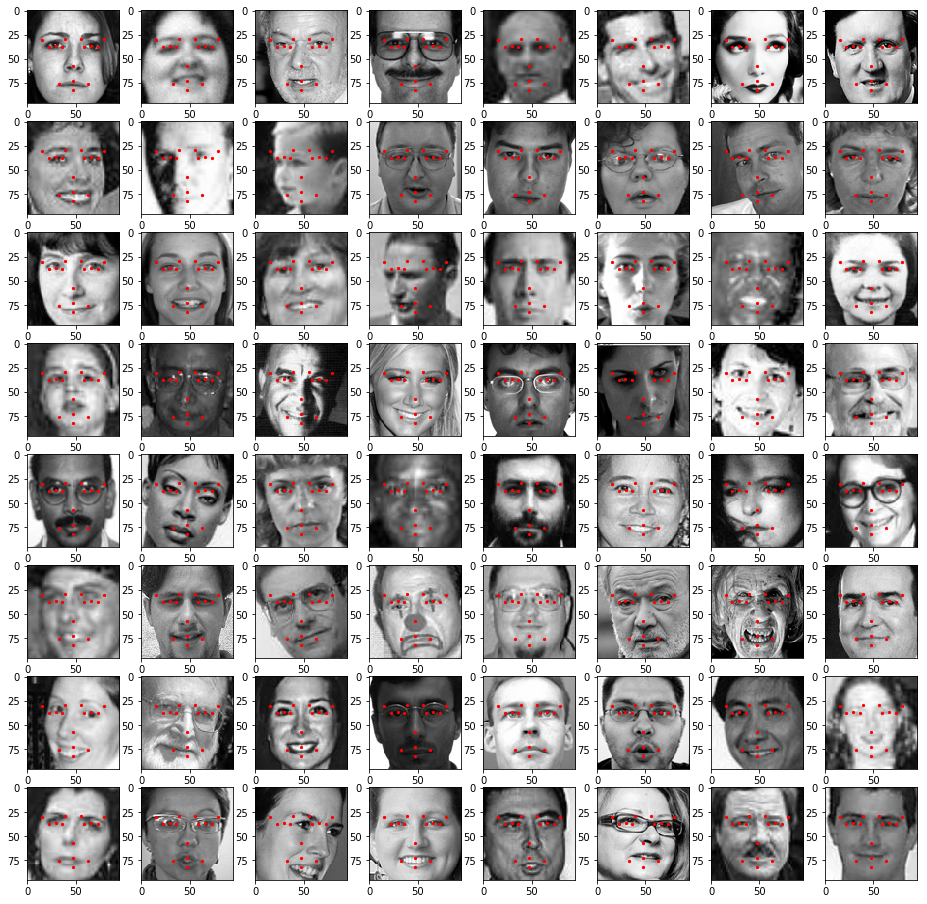

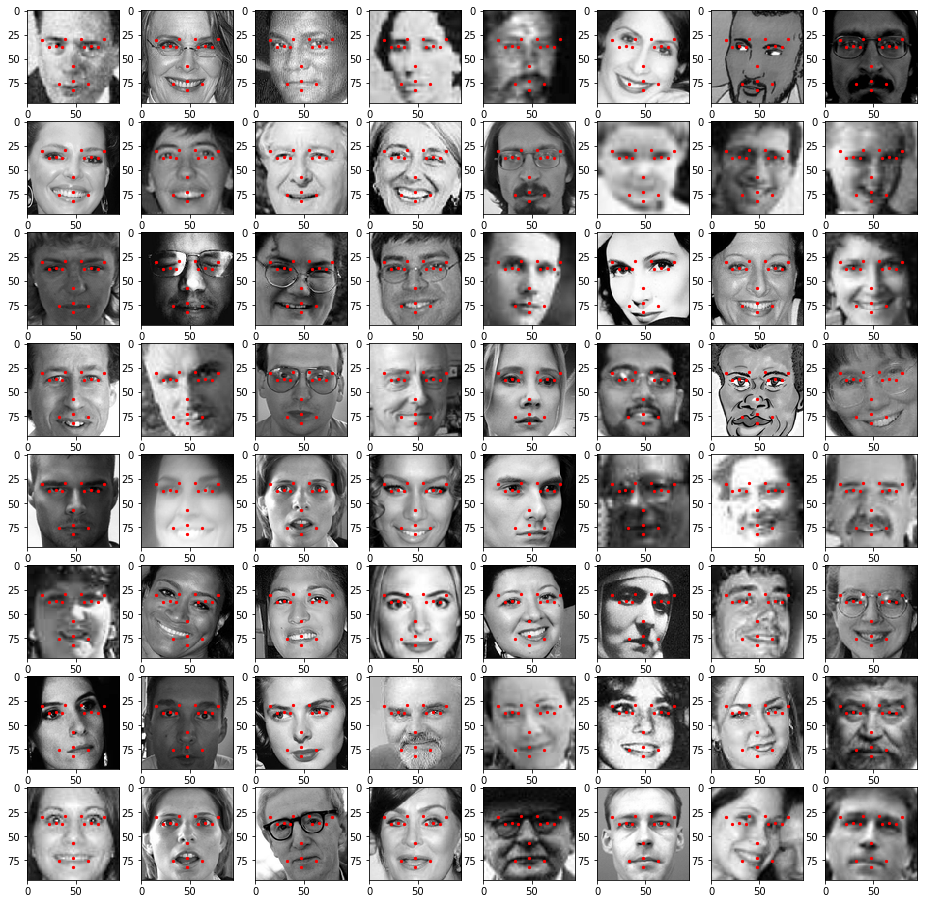

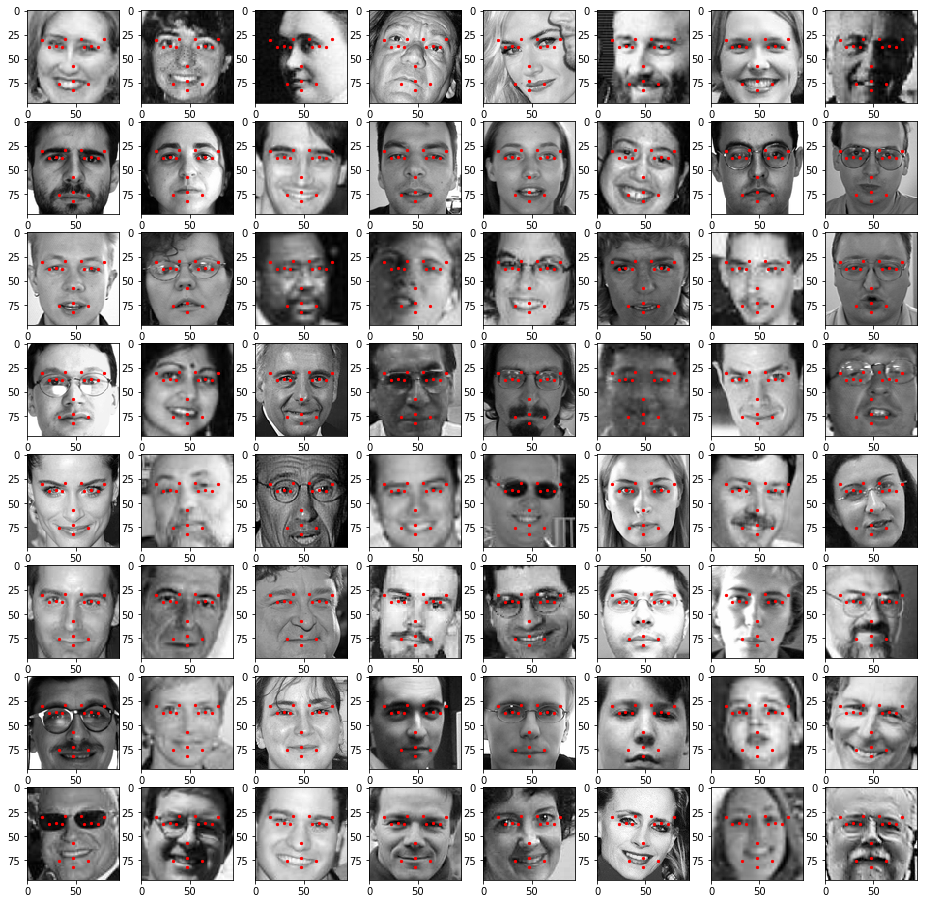

In [0]:
Test(model)

# Total Number of Learnable parameters

In [0]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
print("Total Number of Learnable Parameters: ",pytorch_total_params)

In [0]:
val=FaceDataset(sampler='valid', transform=None)
valid_loader = DataLoader(val, batch_size=64, shuffle=True, num_workers=4)


In [0]:
for img, lab in valid_loader:
  printGrid(img, model)


In [0]:
img.size()

torch.Size([64, 1, 96, 96])